In [ ]:
import re
import string
import nltk
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import squarify
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, accuracy_score, roc_curve, f1_score, recall_score, precision_score
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, EvalPrediction, get_scheduler
from torch.utils.data import DataLoader, Dataset
from datasets import Dataset
from wordcloud import WordCloud

c:\Users\pokem\anaconda3\envs\joynet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('training_data.csv',  encoding='ISO-8859-1', header=None)
data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
data = data.drop(columns=['id', 'id', 'date', 'query', 'user_id'])
data['sentiment'] = data['sentiment'].replace({0: 0, 4: 1})

In [6]:
nltk.download('punkt_tab')
def preprocessing(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    remove_sw = [word for word in tokens if word not in stop_words]
    return ' '.join(remove_sw)
data['cleaned_text'] = data['text'].apply(preprocessing)
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: x if isinstance(x, str) else None)
data = data.dropna(subset=['cleaned_text'])
data.to_csv('cleaned_training_data.csv', index=False)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pokem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### SENTIMENT ANALYSIS WITH BERT

In [3]:

data = pd.read_csv('cleaned_training_data.csv')
x_train, x_test, y_train, y_test = train_test_split(data['cleaned_text'].tolist(), data['sentiment'].tolist(), random_state=42, test_size=0.2)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_input = bert_tokenizer(x_train, padding=True, truncation=True, max_length=128)
test_input = bert_tokenizer(x_test, padding=True, truncation=True, max_length=128)


c:\Users\pokem\anaconda3\envs\joynet\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
train_data = Dataset.from_dict({'input_ids': train_input['input_ids'],
                                'attention_mask': train_input['attention_mask'],
                                'labels': y_train})
test_data = Dataset.from_dict({'input_ids': test_input['input_ids'],
                                'attention_mask': test_input['attention_mask'],
                                'labels': y_test})

### SET UP MODEL TRAINING AND PERFORMANCE METRICS

In [32]:
callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

def compute_metrics(preds, labels):
    preds = np.argmax(preds, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    #eval_steps=2000, 
    #save_steps=2000,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    eval_strategy='epoch',
    save_strategy='epoch',
    report_to="all",
    disable_tqdm=False  
)

train_steps = len(train_data) // training_args.per_device_train_batch_size * training_args.num_train_epochs
lr_scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=training_args.warmup_steps,
    num_training_steps=train_steps
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    optimizers=(optimizer, lr_scheduler),
    callbacks=callbacks,
    compute_metrics=compute_metrics
)

trainer.train()  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\pokem\anaconda3\envs\joynet\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 500/500 [18:06<00:00,  2.17s/it]

  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\pokem\anaconda3\envs\joynet\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\U

{'loss': 0.5735, 'grad_norm': 8.319955825805664, 'learning_rate': 1.25e-05, 'epoch': 1.0}


c:\Users\pokem\anaconda3\envs\joynet\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TypeError: compute_metrics() missing 1 required positional argument: 'labels'

In [3]:
data = pd.read_csv('cleaned_training_data.csv')
random_data = data.sample(n=1000, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(random_data['cleaned_text'].tolist(), random_data['sentiment'].tolist(), random_state=42, test_size=0.2)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
train_input = bert_tokenizer(x_train, padding=True, truncation=True, max_length=96)
test_input = bert_tokenizer(x_test, padding=True, truncation=True, max_length=96)

train_data = Dataset.from_dict({'input_ids': train_input['input_ids'],
                                'attention_mask': train_input['attention_mask'],
                                'labels': y_train })
test_data = Dataset.from_dict({'input_ids': test_input['input_ids'],
                                'attention_mask': test_input['attention_mask'],
                                'labels': y_test })

callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

optimizer_grp_params = [
    {'params': model.bert.encoder.layer[:6].parameters(), 'lr': 4e-5},
    {'params': model.bert.encoder.layer[6:].parameters(), 'lr': 2e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-5}
    ]

optimizer = torch.optim.AdamW(optimizer_grp_params)

def compute_metrics(eval_pred: EvalPrediction):
    preds, labels = eval_pred.predictions, eval_pred.label_ids
    preds = np.argmax(preds, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")
    return {'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    #eval_steps=2000, 
    #save_steps=2000,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    eval_strategy='epoch',
    save_strategy='epoch',
    report_to="all",
    disable_tqdm=False,
    fp16=True,
    max_grad_norm=1.0
)

train_steps = len(train_data) // training_args.per_device_train_batch_size * training_args.num_train_epochs
lr_scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=training_args.warmup_steps,
    num_training_steps=train_steps
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    #optimizers=(optimizer, lr_scheduler),
    optimizers=(optimizer, None),
    callbacks=callbacks,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\pokem\anaconda3\envs\joynet\lib\site-packages\accelerate\accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
  0%|          | 0/150 [00:00<?, ?it/s]c:\Users\pokem\anaconda3\envs\joynet\lib\site-packages\torch\nn\parallel\_functions.py:71: UserWarning: Was as

Accuracy: 0.515, Precision: 0.509537037037037, Recall: 0.515, F1-Score: 0.46300908455625434
{'eval_loss': 0.6874135732650757, 'eval_accuracy': 0.515, 'eval_precision': 0.509537037037037, 'eval_recall': 0.515, 'eval_f1_score': 0.46300908455625434, 'eval_runtime': 4.4523, 'eval_samples_per_second': 44.921, 'eval_steps_per_second': 2.92, 'epoch': 1.0}


c:\Users\pokem\anaconda3\envs\joynet\lib\site-packages\torch\nn\parallel\_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
c:\Users\pokem\anaconda3\envs\joynet\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")
 67%|██████▋   | 100/150 [01:17<00:35,  1.39it/s]

{'loss': 0.6908, 'grad_norm': 817493.25, 'learning_rate': 2e-05, 'epoch': 2.0}


                                                 
 67%|██████▋   | 100/150 [01:21<00:35,  1.39it/s]

Accuracy: 0.58, Precision: 0.6540571428571428, Recall: 0.58, F1-Score: 0.5104540629791249
{'eval_loss': 0.6876780986785889, 'eval_accuracy': 0.58, 'eval_precision': 0.6540571428571428, 'eval_recall': 0.58, 'eval_f1_score': 0.5104540629791249, 'eval_runtime': 4.518, 'eval_samples_per_second': 44.267, 'eval_steps_per_second': 2.877, 'epoch': 2.0}


c:\Users\pokem\anaconda3\envs\joynet\lib\site-packages\torch\nn\parallel\_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
c:\Users\pokem\anaconda3\envs\joynet\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")
100%|██████████| 150/150 [01:58<00:00,  1.42it/s]c:\Users\pokem\anaconda3\envs\joynet\lib\site-packages\torch\nn\parallel\_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
                                                 
100%|██████████| 150/150 [02:04<00:00,  1.42it/s]

Accuracy: 0.66, Precision: 0.660210547626278, Recall: 0.66, F1-Score: 0.6590433122299266
{'eval_loss': 0.6323169469833374, 'eval_accuracy': 0.66, 'eval_precision': 0.660210547626278, 'eval_recall': 0.66, 'eval_f1_score': 0.6590433122299266, 'eval_runtime': 4.4729, 'eval_samples_per_second': 44.714, 'eval_steps_per_second': 2.906, 'epoch': 3.0}


100%|██████████| 150/150 [02:05<00:00,  1.20it/s]

{'train_runtime': 125.4251, 'train_samples_per_second': 19.135, 'train_steps_per_second': 1.196, 'train_loss': 0.6505254491170247, 'epoch': 3.0}


TrainOutput(global_step=150, training_loss=0.6505254491170247, metrics={'train_runtime': 125.4251, 'train_samples_per_second': 19.135, 'train_steps_per_second': 1.196, 'total_flos': 41933324448000.0, 'train_loss': 0.6505254491170247, 'epoch': 3.0})

### PREPARE FOR MODEL ANALYSIS

In [2]:
data = pd.read_csv('cleaned_training_data.csv', encoding='ISO-8859-1')
train_x, test_x, train_y, test_y = train_test_split(
    data['cleaned_text'].tolist(), data['sentiment'].tolist(), random_state=42, test_size=0.2
    )

In [ ]:
model_path = './best_model'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

test_data = tokenizer(test_x, padding=True, truncation=True, max_length=128, return_tensors='pt')


In [ ]:
from torch.utils.data import TensorDataset

dataset = TensorDataset(test_data['input_ids'], test_data['attention_mask'])
dataloader = DataLoader(dataset, batch_size=16)
predictions = []
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        predictions.extend(batch_preds)

[0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,


In [34]:
from sklearn.metrics import classification_report
acc = accuracy_score(test_y, predictions)
precision = precision_score(test_y, predictions, average='weighted')
recall = recall_score(test_y, predictions, average='weighted')
f1 = f1_score(test_y, predictions, average='weighted')
print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8240615716986227
Precision: 0.8241197325866617
Recall: 0.8240615716986227
F1 Score: 0.8240567337040322


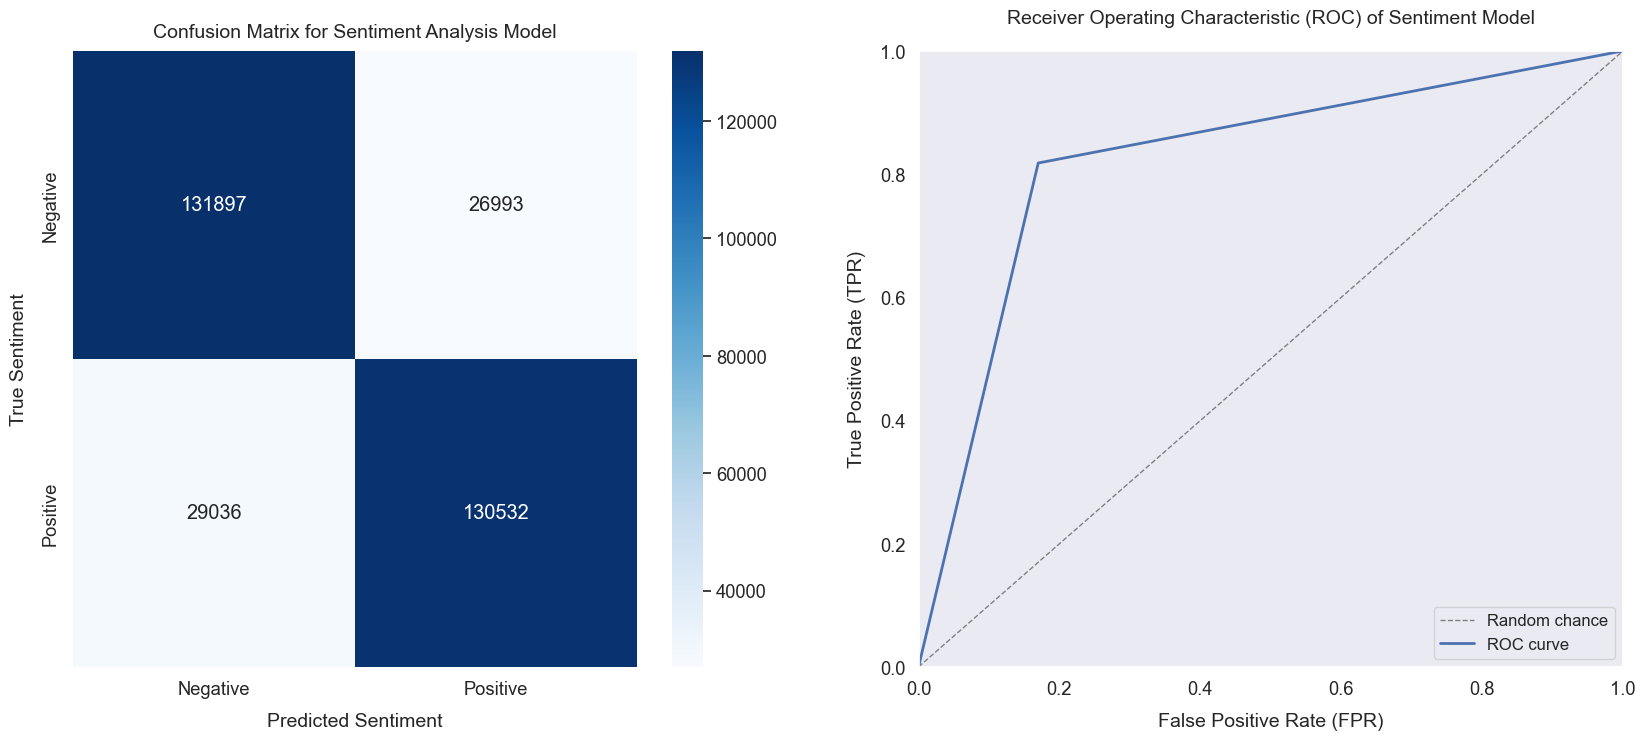

In [36]:
cm = confusion_matrix(test_y, predictions)
plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1, 2, 1)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', )
ax.set_xlabel('Predicted Sentiment', fontsize=14, labelpad=10)
ax.set_ylabel('True Sentiment', fontsize=14, labelpad=10)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_title('Confusion Matrix for Sentiment Analysis Model', fontsize=14, pad=10)

fpr, tpr, thresholds = roc_curve(test_y, predictions, pos_label=1)
plt.subplot(1, 2, 2)
ax = plt.gca()
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1, label='Random chance')
plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
plt.xlabel('False Positive Rate (FPR)', fontsize=14, labelpad=10)
plt.ylabel('True Positive Rate (TPR)', fontsize=14, labelpad=10)
plt.title('Receiver Operating Characteristic (ROC) of Sentiment Model', fontsize=14, pad=20)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(False)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [37]:
performance_data = {
    'metric': ['accuracy', 'precision', 'recall', 'f1 score'],
    'value': [
        accuracy_score(test_y, predictions, normalize=True, sample_weight=None),
        precision_score(test_y, predictions),
        recall_score(test_y, predictions),
        f1_score(test_y, predictions)
    ]
}

performance_df = pd.DataFrame(performance_data)
performance_df.style.hide(axis='index')

metric,value
accuracy,0.824062
precision,0.828643
recall,0.818034
f1 score,0.823304


### GENERATE FILTERED RANKED CONTENT USING SENTIMENT ANALYSIS MODEL

In [ ]:
ranked_df = pd.read_csv('ranked_videos.csv')
ranked_df['combined_text'] = ranked_df['description'] + ' ' + ranked_df['hashtags']

model_path = './best_model'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

def preprocessing(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    remove_sw = [word for word in tokens if word not in stop_words]
    return ' '.join(remove_sw)

def sentiment_predict(text, model, batch_size=32, max_length=128):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
    dataloader = DataLoader(dataset, batch_size=16)
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask = batch
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            predictions.extend(batch_preds)
    return predictions

text = ranked_df['combined_text'].astype(str).apply(preprocessing)
ranked_df['prediction'] = sentiment_predict(text.tolist(), model)
best_videos = ranked_df[ranked_df['prediction'] == '1']

0        honor wisdom ancestors use create future colla...
1        daughter got back fatherdaughter relationship ...
2        blacklivesmatter endracism justice photomagic ...
3        got police bluelivesmatter blacklivesmatter al...
4        easy way add glam look add rhinestones absolut...
                               ...                        
11236    get hair last min knowing got ta trip fyp vira...
11237    definitely vibe fyp dateideas museum museumdat...
11238    stitch tamasi really want laugh blackgirltikto...
11239    stitch decent advice non black women think app...
11240    foodhistory foodhistoryfacts fathersday histor...
Name: combined_text, Length: 11241, dtype: object

In [56]:
ranked_df

,v_id,p_id,search_query,search_days,max_cursor,url,username,description,hashtags,likes,comments,views,collects,shares,video_mp3,engagement_score,rank,combined_text,prediction
0,16772,1,blacktiktok,100000,10000,https://v16m.tiktokcdn-eu.com/4cb71ac121952dfc...,tiktok,"""Honor the wisdom of the ancestors. Use it to ...","#BlackHistoryMonth, #BlackTikTok",526152,2122,197282357,0,5239,https://sf16-ies-music-va.tiktokcdn.com/obj/ie...,1.000000,1.0,"""Honor the wisdom of the ancestors. Use it to ...",1
1,1559044,1,blacklivesmatter,100000,10000,https://v77.tiktokcdn-eu.com/2a7056cec1c0c6315...,lgndfrvr,MY DAUGHTER GOT MY BACK ❤️ #FatherDaughter #Re...,"#FatherDaughter, #Relationship, #BlackLivesMatter",10961910,32618,78734459,0,138962,https://sf16-ies-music-va.tiktokcdn.com/obj/mu...,0.933340,2.0,MY DAUGHTER GOT MY BACK ❤️ #FatherDaughter #Re...,1
2,1559043,1,blacklivesmatter,100000,10000,https://v77.tiktokcdn-eu.com/8e03fb24c7ca7a23d...,jordi.koalitic,#blacklivesmatter 1 or 2 ? 👆🏼 #endracism #just...,"#blacklivesmatter, #endracism, #justice, #phot...",11643314,116008,63787845,0,55096,https://sf16-ies-music-va.tiktokcdn.com/obj/mu...,0.893594,3.0,#blacklivesmatter 1 or 2 ? 👆🏼 #endracism #just...,1
3,1559045,1,blacklivesmatter,100000,10000,https://v77.tiktokcdn-eu.com/bc52bf77cd5088168...,yesmikesaidit,They got me again! #police #bluelivesmatter #b...,"#police, #bluelivesmatter, #blacklivesmatter, ...",6942803,59983,48270521,0,32263,https://sf16-ies-music-va.tiktokcdn.com/obj/ie...,0.583106,4.0,They got me again! #police #bluelivesmatter #b...,1
4,2853885,1,blackgirltiktok,100000,10000,https://v16m.tiktokcdn-eu.com/f08f3bba6d1d5917...,withambernicole,"An easy way to add glam any look, is to add rh...","#howtotiktok, #grwm, #blackgirlluxurytiktok, #...",5195488,44271,60304740,0,33396,https://sf16-ies-music-sg.tiktokcdn.com/obj/to...,0.555890,5.0,"An easy way to add glam any look, is to add rh...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11236,2996250,1,blackgirltiktok,100000,10000,https://v45.tiktokcdn-eu.com/f1d3101fe091b3026...,theyluvvhannahhhhh,This what i get for doing my hair last min kno...,"#fyp, #viral, #fyppppppppppppppppppppppp, #blo...",140160,209,634307,0,432,https://sf16-ies-music-va.tiktokcdn.com/obj/ie...,0.010010,11237.0,This what i get for doing my hair last min kno...,1
11237,2996392,1,blackgirltiktok,100000,10000,https://v77.tiktokcdn-eu.com/b2dba09463888d3cd...,keesopretty,Was definitely a vibe 💌 #fyp #dateideas #museu...,"#fyp, #dateideas, #museum, #museumdate, #trend...",134192,218,650206,0,11344,https://sf16-ies-music-va.tiktokcdn.com/obj/mu...,0.010010,11238.0,Was definitely a vibe 💌 #fyp #dateideas #museu...,1
11238,2856926,1,blackgirltiktok,100000,10000,https://v77.tiktokcdn-eu.com/c45aade951224b5ae...,the_versachi,#stitch with @Andrea Tamasi I really want to l...,"#stitch, #blackgirltiktok, #relatable, #jokeso...",115736,1180,834201,0,10134,https://sf16-ies-music-va.tiktokcdn.com/obj/ie...,0.010007,11239.0,#stitch with @Andrea Tamasi I really want to l...,1
11239,2967524,1,blackbeauty,100000,10000,https://v58.tiktokcdn-eu.com/video/tos/maliva/...,crystaluncut,#stitch with @Avery this is decent advice for ...,"#stitch, #prettyprivilege, #prettyatwork, #pre...",109357,2119,927295,0,1477,https://sf16-ies-music-va.tiktokcdn.com/obj/ie...,0.010004,11240.0,#stitch with @Avery this is decent advice for ...,1


In [62]:
best_videos = ranked_df[ranked_df['prediction'] == 1]
best_videos.drop(columns=['collects', 'combined_text', 'search_days', 'max_cursor', 'prediction'])
best_videos.to_csv('best_videos.csv', index=False)

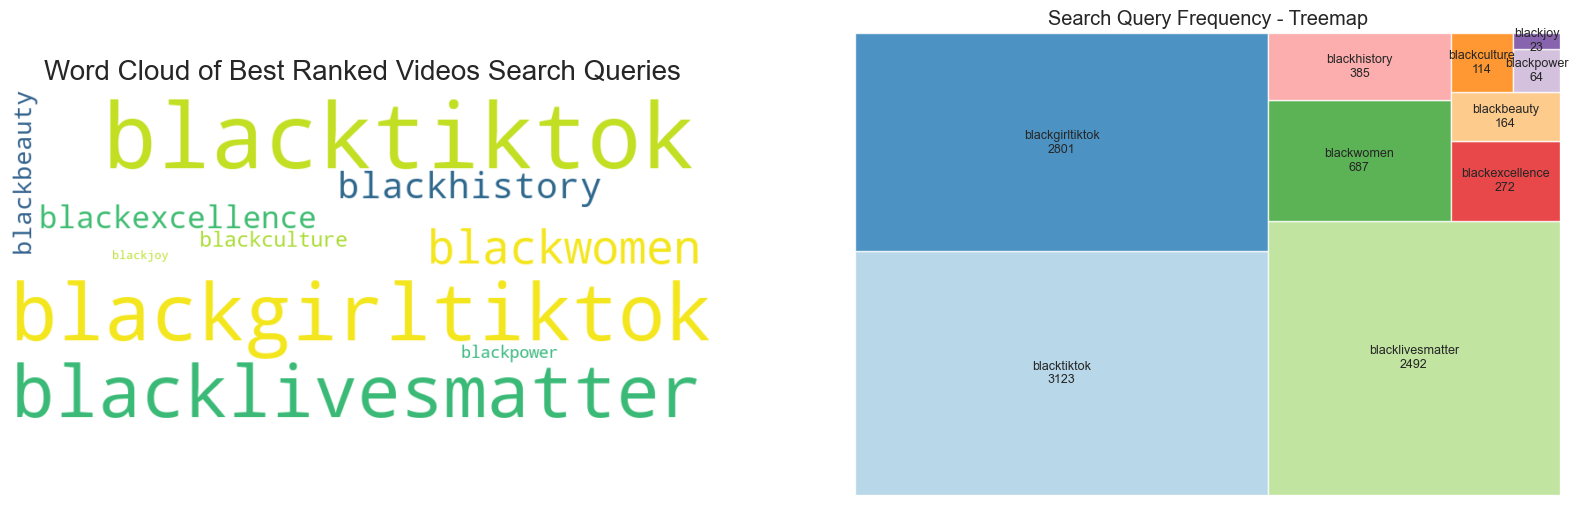

In [ ]:
cnts = best_videos['search_query'].value_counts()

wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white').generate_from_frequencies(cnts)
labels = [f"{query}\n{count}" for query, count in zip(cnts.index, cnts.values)]

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Best Ranked Videos Search Queries', size=20)

plt.subplot(1, 2, 2)
squarify.plot(
    sizes=cnts.values,
    label=labels,
    alpha=0.8,
    color=plt.cm.Paired.colors,
    text_kwargs={'fontsize': 9, 'wrap': True}
)
plt.title("Search Query Frequency - Treemap")
plt.axis('off')
plt.show()